In [1]:
from itertools import chain
from random import random

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from society.action import Action
from society.agent import Agent
from society.simulations.adaptive import AdaptiveSimulation
from society.agents.constant import AllC, AllD
from society.agents.qlearning import TabularQLearner
from society.agents.random import Random
from society.agents.tft import TitForTat
from society.visualisation.network import *

# plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.figsize"] = (12, 5)

In [2]:
# def generate_population(communities, size):
#     population = communities * size

#     agents = [
#         TabularQLearner(lookback=1, epsilon=0.1, learning_rate=0.05)
#         for i in range(population)
#     ]

#     G = nx.connected_caveman_graph(communities, size)

#     weights_matrix = np.zeros((population, population))
#     for u, v, d in G.edges(data=True):
#         weights_matrix[u, v] = weights_matrix[v, u] = 1
#         try:
#             d["weight"] = weights_matrix[u, v]
#         except:
#             d["weight"] = 0

#     return agents, weights_matrix, G

In [3]:
def generate_population(communities, size):
    population = communities * size

    agents = [
        TabularQLearner(lookback=1, epsilon=0.05, learning_rate=0.05, discount_factor=0.98)
        for i in range(population)
    ]

    # agents[0] = TitForTat()
    # agents[16] = TitForTat()
    # agents[16] = TitForTat()
    # agents[31] = TitForTat()

    G = nx.connected_caveman_graph(communities, size)

    # G = nx.Graph()
    # G.add_weighted_edges_from([
    #     (0, i, 1) for i in range(1, population)
    # ])

    weights_matrix = np.zeros((population, population))
    for u, v, d in G.edges(data=True):
        weights_matrix[u, v] = weights_matrix[v, u] = 1
        try:
            d["weight"] = weights_matrix[u, v]
        except:
            d["weight"] = 0

    return agents, weights_matrix, G

In [4]:
# _, _, G = generate_population(2, 16)

# nx.draw(G, pos=nx.spring_layout(G), font_color="white", with_labels=True)

In [5]:
def compute_policies(agents):
    policies = [
        agent._q_table.argmax(axis=-1)
        if hasattr(agent, "_q_table") else None
        for agent in agents
    ]

    return [
        "".join(
            [
                ("C", "D")[policy[i]]
                for i in range(4)
                # for j in range(4)
                # for k in range(4)
            ]
        )
        if policy is not None else "OTHER"
        for policy in policies
    ]

def calculate_cooperativeness(history):
    count = history.count(Action.COOPERATE)

    return count / len(history)

In [6]:
PAYOFF_LABELS = ["(C, C)", "(C, D)", "(D, C)", "(D, D)"]
# PAYOFF_LABELS = ["R", "S", "T", "P"]

Run 1:   0%|          | 0/20000 [00:00<?, ?it/s]

BEST AGENT: 114355 (0.7244947009407833, CDCC)
WORST AGENT: 87848 (0.7608259100973174, CDDC)


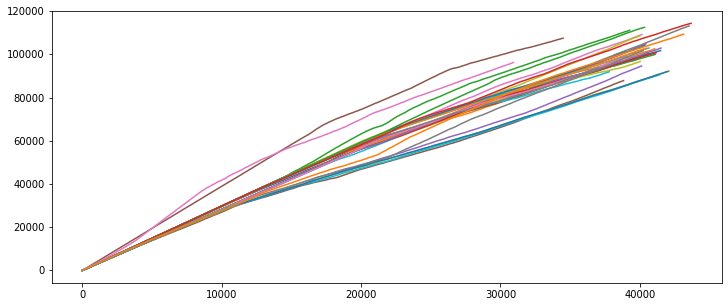

In [7]:
POPULATION = (8, 8)
ROUNDS = 20_000

run_rewards = []
run_cumulative_rewards = []
# run_action_histories = []
run_reward_histories = []
run_policies = []

for run in range(1):
    # Generate a new population
    agents, weights_matrix, G = generate_population(*POPULATION)

    # Run a number of rounds
    sim = AdaptiveSimulation(agents, weights_matrix)

    # Run the simulation
    sim.reset()
    for i in tqdm(range(ROUNDS), desc=f"Run {run + 1}"):
        sim.play_round(train=True)

    # Store results
    run_rewards.append(sim.rewards)
    # run_action_histories.append(sim.action_histories)
    run_reward_histories.append(sim.reward_histories)
    run_policies.append(compute_policies(agents))

    # Output statistics for the best and worst agents
    cumulative_rewards = [(i, sum(history)) for i, history in enumerate(sim.reward_histories)]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    # TODO: maybe I should switch to mean rewards (?)
    # mean_rewards = [(i, np.mean(history)) for i, history in enumerate(sim.reward_histories)]
    # mean_rewards.sort(key=lambda x: x[1], reverse=True)

    tqdm.write(
        f"BEST AGENT: {cumulative_rewards[0][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[0][0]])))}, {run_policies[-1][cumulative_rewards[0][0]]})"
    )
    tqdm.write(
        f"WORST AGENT: {cumulative_rewards[-1][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[-1][0]])))}, {run_policies[-1][cumulative_rewards[-1][0]]})"
    )

    for rh in sim.reward_histories:
        plt.plot(np.cumsum(rh))
    
    plt.show()


In [8]:
sim.calculate_weights()

[[0.5934995547640249,
  0.6429210390504042,
  0.6417673455298585,
  0.6516695957820738,
  0.6189246551114255,
  0.6386915887850467,
  0.4852813852813853],
 [0.7371419163648337,
  0.8755069957553844,
  0.8170169063043135,
  0.8628113596699984,
  0.7786233640329617,
  0.7500253850059232],
 [0.5934995547640249,
  0.7371419163648337,
  0.772813487881981,
  0.685797736400146,
  0.7569420035149385,
  0.6927972900695311,
  0.6370334180183701],
 [0.6429210390504042,
  0.8755069957553844,
  0.772813487881981,
  0.8250523377529658,
  0.8845227858985383,
  0.771734623358673,
  0.759542835904107],
 [0.6417673455298585,
  0.8170169063043135,
  0.685797736400146,
  0.8250523377529658,
  0.8165648336727767,
  0.7254539166522566,
  0.6905584129316679],
 [0.6516695957820738,
  0.8628113596699984,
  0.7569420035149385,
  0.8845227858985383,
  0.8165648336727767,
  0.7518120339864748,
  0.7911899944822512],
 [0.6189246551114255,
  0.7786233640329617,
  0.6927972900695311,
  0.771734623358673,
  0.7254539

In [9]:
sim.action_histories[0][2]

[<Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERA

In [10]:
cumulative_rewards[0][0]

23

In [11]:
if hasattr(agents[cumulative_rewards[0][0]], "_q_table"):
    agents[cumulative_rewards[0][0]]._q_table

In [12]:
agents[1]._q_table

array([[126.17399938, 114.63068167],
       [108.36797791, 113.07819329],
       [111.16769124, 105.08534951],
       [113.91800882, 107.10988707]])

In [13]:
# from datetime import datetime
# import pickle

# with open(f"results - {datetime.isoformat(datetime.now()).replace(':', '-')}.pickle", "wb") as f:
#     pickle.dump({
#         "rewards": run_rewards,
#         "cumulative_rewards": run_cumulative_rewards,
#         # "action_histories": run_action_histories,
#         "reward_histories": run_reward_histories,
#         "policies": run_policies,
#     }, f)


In [14]:
cumulative_reward_policy_ranks = {}
cumulative_reward_policies = {}

for policies, reward_histories in zip(run_policies, run_reward_histories):
    cumulative_rewards = [(i, sum(history)) for i, history in enumerate(reward_histories)]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    for rank, (i, cumulative_reward) in enumerate(cumulative_rewards):
        policy = policies[i]

        if policy not in cumulative_reward_policy_ranks:
            cumulative_reward_policy_ranks[policy] = []
            cumulative_reward_policies[policy] = []

        cumulative_reward_policy_ranks[policy].append(rank + 1)
        cumulative_reward_policies[policy].append(cumulative_reward)

mean_cumulative_reward_policy_ranks = {policy: np.mean(ranks) for policy, ranks in cumulative_reward_policy_ranks.items()}
mean_cumulative_reward_policies = {policy: np.mean(rewards) for policy, rewards in cumulative_reward_policies.items()}

In [15]:
for policy in sorted(mean_cumulative_reward_policy_ranks, key=lambda x: mean_cumulative_reward_policy_ranks[x]):
    print(f"{mean_cumulative_reward_policy_ranks[policy]:<24} {policy}")

8.0                      CCCD
11.5                     DDDC
13.857142857142858       CDDC
15.6                     CDDD
17.5                     CDCD
17.714285714285715       CDCC
18.0                     DDDD
24.0                     CCDD
25.0                     CCCC


In [16]:
for policy in sorted(mean_cumulative_reward_policies, key=lambda x: mean_cumulative_reward_policies[x], reverse=True):
    print(f"{mean_cumulative_reward_policies[policy]:<24} {policy}")

107498.0                 CCCD
105115.0                 DDDC
103698.71428571429       CDDC
101476.0                 CDDD
100789.28571428571       CDCC
99714.33333333333        DDDD
99712.0                  CDCD
96269.0                  CCDD
95398.0                  CCCC


In [17]:
compute_policies([agents[cumulative_rewards[0][0]]])

['CDCC']

In [18]:
if hasattr(agents[cumulative_rewards[0][0]], "_q_table"):
    agents[cumulative_rewards[0][0]]._q_table

In [19]:
from itertools import product

P = compute_policies([agents[cumulative_rewards[0][0]]])[0]

for m, p in zip(product(PAYOFF_LABELS), P):
    print(m, "=>", p)

('(C, C)',) => C
('(C, D)',) => D
('(D, C)',) => C
('(D, D)',) => C
